In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import copy
from collections import Counter
from utils_football import *

In [2]:
with open("events/events_Spain.json") as f:
    data_spain = json.load(f)

In [3]:
# loading common files

with open("players.json") as f:
    players = json.load(f)
with open("teams.json") as f:
    teams = json.load(f) 

In [4]:
tags_name = pd.read_csv("tags2name.csv")
events_name = pd.read_csv("eventid2name.csv")

In [5]:
events_label = events_name.groupby(['event','event_label']).size().reset_index()
events_label = events_label.loc[:,['event', 'event_label']]
events_label.set_index("event", inplace = True)

In [6]:
teams_obeject = utils(teams)
teams_df = teams_obeject.creat_df()
teams_df.set_index("wyId", inplace = True)
teams_df = teams_df.rename(columns = {'name': 'team'})
teams_df['team'] = [item.encode().decode('unicode_escape') for item in list(teams_df['team'])]  

In [7]:
players_obeject = utils(players)
players_df = players_obeject.creat_df()
players_df.set_index("wyId", inplace = True)
players_df.rename(columns = {"shortName": "player"}, inplace = True)
players_df['player'] = [item.encode().decode('unicode_escape') for item in list(players_df['player'])]  

In [8]:
spain_object = events(data_spain, 'Spain', tags_name, events_label)
spain_event_data = spain_object.process(teams_df, players_df, output = True)

In [9]:
def plot_player(ax, player_name, colname, value, alpha = 1, marker="o", color = 'red', markersize=12, title = None):
    filt = (spain_event_data["player"] == player_name) & (spain_event_data[colname] == value)
    positions = spain_event_data[filt]['positions']
    initial_position = [item[0] for item in positions]
    position_obj = utils(initial_position)
    initla_positions = position_obj.combined_dict()
    x_val = [x*1.25 for x in initla_positions["x"]]
    y_val = [y*0.85 for y in initla_positions["y"]]

    img = plt.imread("Soccer_field.png")
    ax.imshow(img,  extent=[-5, 131, -3, 88])
    ax.scatter(x = x_val, y = y_val, alpha = alpha, marker=marker, color = color, s = markersize)
    ax.set_ylim(-1, 88)
    ax.set_xlim(-3, 131)
    ax.set_ylim(ax.get_ylim()[::-1]) 
    if title is None:
        ax.set_title(f"{player_name} {title}")
    else:
        ax.set_title(f"{player_name} {title}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

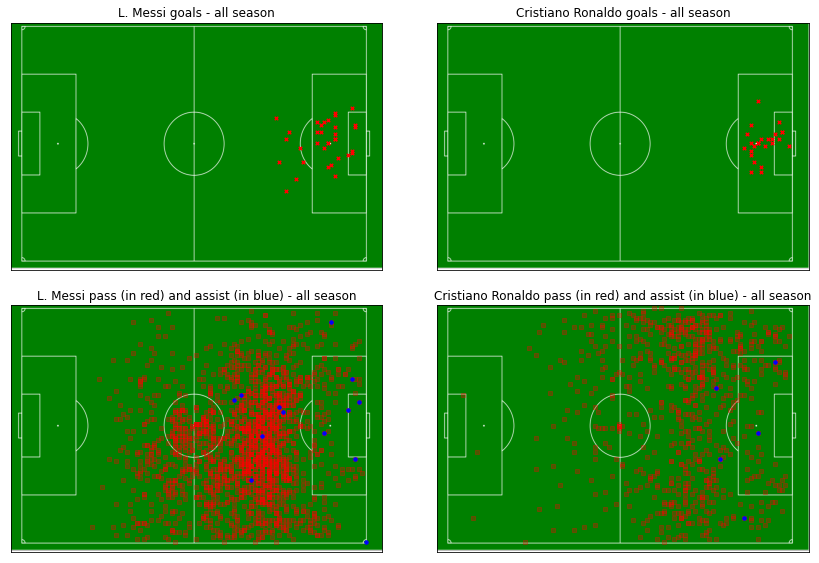

In [10]:
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize'] = [12, 8]
gs = gridspec.GridSpec(2, 2, 
                width_ratios=[15, 15],  height_ratios=[1, 1] )

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])


plot_player(ax1, "L. Messi", "Goal", 1, marker="x", title = 'goals - all season')
plot_player(ax2,"Cristiano Ronaldo", "Goal", 1, marker="x", title = 'goals - all season')
plot_player(ax3,"L. Messi", "eventName", "Pass", alpha = .3, marker="s", markersize = 12)

plot_player(ax3,"L. Messi", "assist", 1, alpha = 1, marker="o", color= 'blue', title = 'pass (in red) and assist (in blue) - all season')
plot_player(ax4,"Cristiano Ronaldo", "eventName", "Pass", alpha = .3, marker="s", markersize = 12)

plot_player(ax4,"Cristiano Ronaldo", "assist", 1, alpha = 1, marker="o", color= 'blue', title = 'pass (in red) and assist (in blue) - all season')

plt.tight_layout()
plt.show()

In [11]:
def dist(givenlist):
    pos1 = givenlist[0]
    pos2 = givenlist[1]
    dist = (pos1["x"]*1.25 - pos2["x"]*1.25)**2 + (pos1["y"]*.85 - pos2["y"]*.85)**2
    dist = dist**.5
    return dist

In [12]:
filt = (spain_event_data["player"] == "L. Messi") & (spain_event_data["eventName"] == "Pass")
positions_messi = spain_event_data[filt]['positions']

filt = (spain_event_data["player"] == "Cristiano Ronaldo") & (spain_event_data["eventName"] == "Pass")
positions_ron = spain_event_data[filt]['positions']


In [13]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', edgecolor='g',
                         label='Lionel Messi'), 
                Patch(facecolor='blue', edgecolor='b',
                         label='Cristiano Ronaldo')]

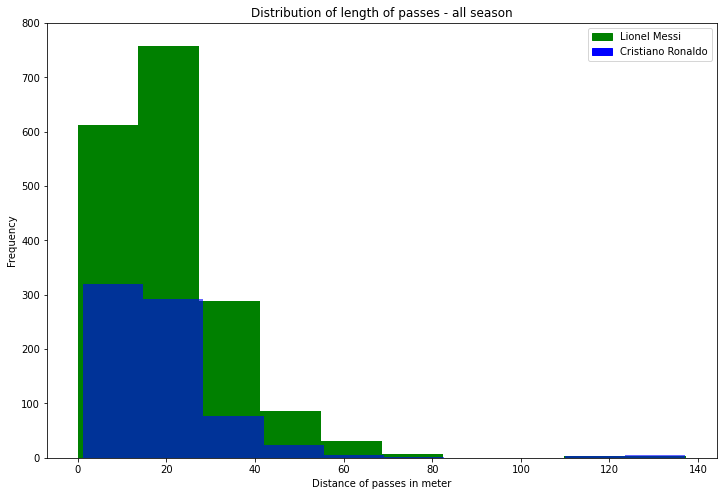

In [14]:
fig, ax = plt.subplots()
ax.hist(positions_messi.apply(dist), color = 'green')
ax.hist(positions_ron.apply(dist), color = 'blue', alpha = .6)
ax.legend(handles=legend_elements, loc='upper right')
ax.set_ylim(0, 800)
ax.set_ylabel("Frequency")
ax.set_xlabel("Distance of passes in meter")
ax.set_title('Distribution of length of passes - all season')
plt.show()

In [15]:
def player_goal_involvement(df, player, team, time_gap):
    df_filter = df[df["team"] == team]
    df_filter_ind = list(df_filter[df_filter['Goal'] == 1].index)
    events = []
    subevents = []
    positions = []
    eventsec = []
    for ind in df_filter_ind:
        time1 = df_filter.loc[ind, 'eventSec']
        time0 = df_filter.loc[ind, 'eventSec'] - time_gap
        match = df_filter.loc[ind, 'matchId']
        filt = (df_filter['matchId'] == match) & (df_filter['eventSec']>= time0) & (df_filter['eventSec'] <= time1) & (df_filter['player'] == player)
        eventsec.append(list(df_filter[filt]['eventSec']))
        positions.append(list(df_filter[filt]['positions']))
        events.append(list(df_filter[filt]['eventName']))
        subevents.append(list(df_filter[filt]['subEventName'])) 
    return events, subevents, positions, eventsec

In [16]:
team = 'Barcelona'
player ="L. Messi"
time_gap = 10

events_messi, subevents_messi, positions_messi, eventsec_messi = player_goal_involvement(spain_event_data, player, team, time_gap)

In [17]:
team = 'Real Madrid'
player ="Cristiano Ronaldo"
time_gap = 10

events_ron, subevents_ron, positions_ron, eventsec_ron = player_goal_involvement(spain_event_data, player, team, time_gap)

In [18]:
def plot_player_involve(ax, positions, player_name, alpha = 1, marker="o", color = 'red', title = None):
    all_posn = []
    for item in positions:
        for i in range(len(item)):
            all_posn.append(item[i])
    all_posn = [item[0] for item in all_posn]
    position_obj = utils(all_posn)
    positions_comb = position_obj.combined_dict()
    x_val = [x*1.25 for x in positions_comb["x"]]
    y_val = [y*0.85 for y in positions_comb["y"]]

#     img = plt.imread("Soccer_field_accurate.png")
    img = plt.imread("Soccer_field.png")
    ax.imshow(img,  extent=[-5, 131, -3, 88])
    ax.scatter(x = x_val, y = y_val, alpha = alpha, marker=marker, color = color)
    ax.set_ylim(-1, 88)
    ax.set_xlim(-3, 131)
    ax.set_ylim(ax.get_ylim()[::-1]) 
    if title is None:
        ax.set_title(f"{player_name}")
    else:
        ax.set_title(f"{player_name} {title}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

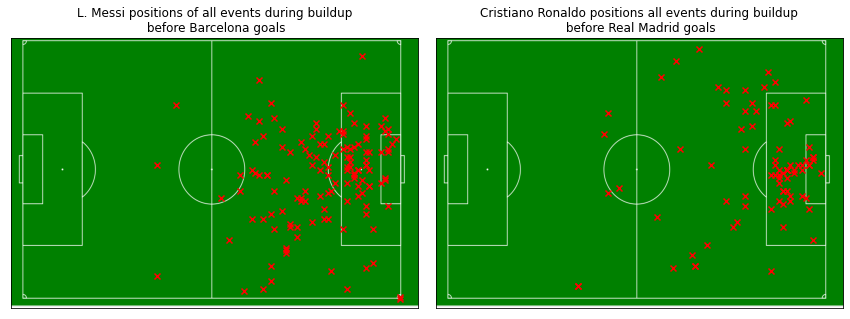

In [30]:
plt.rcParams['figure.figsize'] = [12, 8]
gs = gridspec.GridSpec(1, 2, 
                width_ratios=[15, 15],  height_ratios=[1] )

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

plot_player_involve(ax1, positions_messi, "L. Messi", marker="x", title = 'positions of all events during buildup\n before Barcelona goals')
plot_player_involve(ax2, positions_ron, "Cristiano Ronaldo", marker="x", title = 'positions all events during buildup\n before Real Madrid goals')

plt.tight_layout()
plt.show()

In [20]:
def events_dist_goal(event_list):
    [item.append("Not involved") if not item else item for item in event_list]
    all_events = []
    for item in event_list:
        for i in range(len(item)):
            all_events.append(item[i])
    c = Counter(all_events)
    freq = pd.DataFrame.from_dict(c, orient='index').reset_index()
    freq.columns = ['events', 'count']
    freq = freq.sort_values('events', ascending = False)
    return freq

In [21]:
freq_messi = events_dist_goal(events_messi)
freq_ron = events_dist_goal(events_ron)

In [22]:
def plot_bar(ax1):
    filt_messi = (freq_messi['events'] == 'Not involved')
    freq_messi_rest = freq_messi[-filt_messi]
    filt_ron = (freq_ron['events'] == 'Not involved')
    freq_ron_rest = freq_ron[-filt_ron]


    width = 0.35  # the width of the bars

    x = np.arange(len((freq_messi_rest['events'])))  # the label locations
#     fig, ax = plt.subplots()
    rects1 = ax1.bar(x - width/2, freq_messi_rest['count'], width, label='L. Messi', color = 'limegreen')
    rects2 = ax1.bar(x + width/2, freq_ron_rest['count'], width, label='Cristiano Ronaldo', color = 'royalblue')

    ax1.set_ylabel('Number')
    ax1.set_xlabel('Event name')
    ax1.set_title('Player involvement during buildup for goals scored by teams - all season')
    ax1.set_xticks(x)
    ax1.set_xticklabels(freq_messi_rest['events'])
    ax1.legend()

In [23]:
team_name = list(spain_event_data.groupby('team').Goal.sum().loc[['Barcelona', 'Real Madrid']].index)
team_goals = list(spain_event_data.groupby('team').Goal.sum().loc[['Barcelona', 'Real Madrid']])

In [24]:
player_name = list(spain_event_data.groupby('player').Goal.sum().loc[['L. Messi', 'Cristiano Ronaldo']].index)
player_goals = list(spain_event_data.groupby('player').Goal.sum().loc[['L. Messi', 'Cristiano Ronaldo']])

In [25]:
mess_not_involve = float(freq_messi[freq_messi['events'] == 'Not involved']['count'])
ron_not_involve = float(freq_ron[freq_ron['events'] == 'Not involved']['count'])

In [26]:
labels_in = ['Involved', 'Not Involved']
ni = [round(mess_not_involve*100/team_goals[0], 1), round(ron_not_involve*100/team_goals[1], 1)]
size_messi = [100-ni[0], ni[0]]
size_ron = [100-ni[1], ni[1]]

In [27]:
def pie_involve(ax2, ax3):

    ax2.pie(size_messi, labels = labels_in, autopct='%1.1f%%',
            shadow=False, startangle=90, colors = ['orange', 'teal'], labeldistance = None)
    ax2.set_title('L. Messi involvement(%) during buildup\n prior to Barcelona goals-all season')

    ax3.pie(size_ron, labels = labels_in, autopct='%1.1f%%',
            shadow=False, startangle=90, colors = ['orange', 'teal'], labeldistance = None)
    ax3.set_title('Cristiano Ronaldo involvement(%) during buildup\n prior to Real Madrid goals-all season')
    handles, labels = ax3.get_legend_handles_labels()
    ax2.legend(handles, labels, loc = (1.2, 0))


C:\Users\maruf\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':


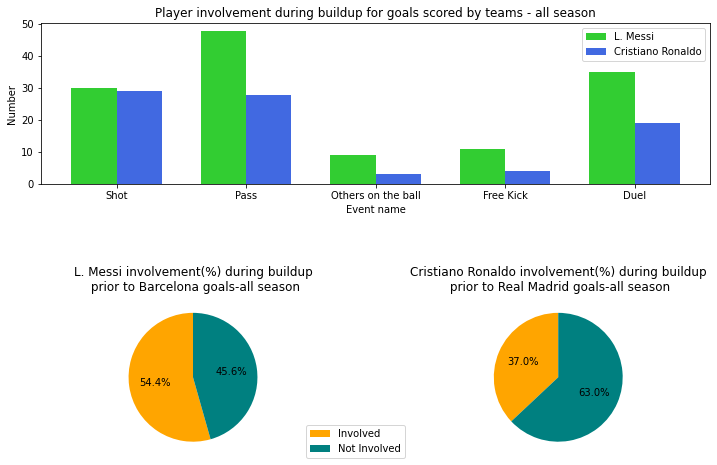

In [28]:
plt.rcParams['figure.figsize'] = [12, 8]
gs = gridspec.GridSpec(2, 2, 
                width_ratios=[15, 15],  height_ratios=[1, 1], hspace = .7)

ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])

plot_bar(ax1)
pie_involve(ax2, ax3)

plt.tight_layout()

plt.show()
